# 기본과제: DistilBERT로 뉴스 기사 분류 모델 학습하기

이번 실습에서는 pre-trained된 DistilBERT를 불러와 이전 주차 실습에서 사용하던 뉴스 기사 분류 모델 문제에 적용합니다. 먼저 필요한 library들을 불러옵니다.

In [26]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses dataset torch torchvision torchaudio matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


그 후, 우리가 사용하는 DistilBERT pre-training 때 사용한 tokenizer를 불러옵니다.

In [27]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader

tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

Using cache found in /Users/user/.cache/torch/hub/huggingface_pytorch-transformers_main


## [MY CODE] AG_News dataset 준비
Huggingface dataset의 fancyzhx/ag_news를 load합니다.

collate_fn 함수를 수정해서, Truncation과 관련된 부분들을 지웁니다.

In [3]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader

ds = load_dataset('fancyzhx/ag_news')

def collate_fn(batch):
    max_len = 400
    texts, labels = [], []
    for row in batch:
        labels.append(row['label'])
        texts.append(row['text'])

    # Truncation 관련 부분 제거, max_length는 유지
    texts = torch.LongTensor(tokenizer(texts, padding=True, max_length=max_len).input_ids)
    labels = torch.LongTensor(labels)

    return texts, labels

train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

## [MY CODE] 데이터 확인
해당 ds에 어떤 데이터가 존재하는지 데이터를 확인합니다.

In [4]:
# 처음 5개의 데이터를 확인
for i in range(5):
    print(ds['train'][i])

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}
{'text': 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.', 'label': 2}
{'text': "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.", 'label': 2}
{'text': 'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\\flows from the main pipeline in southern Iraq after\\intelligence showed a rebel militia could strike\\infrastructure, an oil official said on Saturday.', 'lab

## [MY CODE] ds output 라벨 수 확인
분류 문제로 변경되었기 때문에, output을 class 숫자로 변경해야 합니다. 분류 모델의 대상이 될 class의 수(라벨 수)로 output이 형성되어야 하기 때문에, 먼저 해당 dataset의 라벨수 즉, 클래스 수를 확인합니다.

In [5]:
# 고유한 라벨 확인
unique_labels = set(ds['train']['label'])
num_classes = len(unique_labels)

print(f"클래스 수: {num_classes}")
print(f"고유 라벨: {unique_labels}")

클래스 수: 4
고유 라벨: {0, 1, 2, 3}


## [MY CODE] Classifier output 수정
위에서 확인한 클래스 수로 TextClassifier model의 output을 변경합니다.

In [6]:
from torch import nn

class TextClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
        self.classifier = nn.Linear(768, num_classes)

    def forward(self, x):
        x = self.encoder(x)['last_hidden_state']
        x = self.classifier(x[:, 0])

        return x
    
num_classes = len(unique_labels)
model = TextClassifier(num_classes)    

Using cache found in /Users/user/.cache/torch/hub/huggingface_pytorch-transformers_main


## [MY CODE] 손실 함수 수정
분류 문제의 손실함수인 CrossEntropyLoss로 손실함수를 수정합니다.

In [7]:
loss_fn = nn.CrossEntropyLoss()

In [8]:
for param in model.encoder.parameters():
  param.requires_grad = False

위의 코드는 `encoder`에 해당하는 parameter들의 `requires_grad`를 `False`로 설정하는 모습입니다.
`requires_grad`를 `False`로 두는 경우, gradient 계산 및 업데이트가 이루어지지 않아 결과적으로 학습이 되지 않습니다.
즉, 마지막 `classifier`에 해당하는 linear layer만 학습이 이루어집니다.
이런 식으로 특정 부분들을 freeze하게 되면 효율적으로 학습을 할 수 있습니다.

## [MY CODE] accuracy 함수도 classification에 맞춰 수정
기존과 다르게, 여러 클래스에 대한 확률 분포를 나타내므로 argmax 함수로 수정하여 정확도를 측정합니다.

In [28]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)
    # preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

마지막으로 이전과 같은 코드를 사용하여 학습 결과를 확인해봅시다.

분류 문재이므로, label을 long() 타입으로 model(inputs)[..., 0]을 전체 출력 차원을 활용하도록 model(inputs) 으로 변경합니다.

In [31]:
import time
from torch.optim import Adam
import numpy as np

device = torch.device("mps")
lr = 0.001
model = model.to(device)
train_acc_list = []
test_acc_list = []

optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 10

for epoch in range(n_epochs):
  start_time = time.time()  # epoch 시작 시간 기록
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device).long()

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  print(f"Epoch {epoch:3d} | Train Loss: {total_loss:.4f}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    end_time = time.time()  # epoch 끝 시간 기록
    epoch_duration = end_time - start_time  # 걸린 시간 계산
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}| Duration: {epoch_duration:.2f} seconds")

/opt/homebrew/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2691: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch   0 | Train Loss: 716.0134
=========> Train acc: 0.884 | Test acc: 0.878| Duration: 1256.64 seconds
Epoch   1 | Train Loss: 683.9905
=========> Train acc: 0.886 | Test acc: 0.882| Duration: 1267.49 seconds
Epoch   2 | Train Loss: 666.3999
=========> Train acc: 0.887 | Test acc: 0.885| Duration: 1237.73 seconds
Epoch   3 | Train Loss: 657.4530
=========> Train acc: 0.889 | Test acc: 0.886| Duration: 1267.91 seconds
Epoch   4 | Train Loss: 649.6620
=========> Train acc: 0.891 | Test acc: 0.887| Duration: 1257.18 seconds
Epoch   5 | Train Loss: 643.3723
=========> Train acc: 0.891 | Test acc: 0.889| Duration: 1262.70 seconds
Epoch   6 | Train Loss: 643.8419
=========> Train acc: 0.891 | Test acc: 0.888| Duration: 1258.69 seconds
Epoch   7 | Train Loss: 640.1441
=========> Train acc: 0.892 | Test acc: 0.890| Duration: 1250.21 seconds
Epoch   8 | Train Loss: 635.9692
=========> Train acc: 0.893 | Test acc: 0.890| Duration: 1236.33 seconds
Epoch   9 | Train Loss: 632.2616
=========> Tr

## [MY CODE]
그래프를 통해 위의 전반적인 측정 결과를 확인합니다.

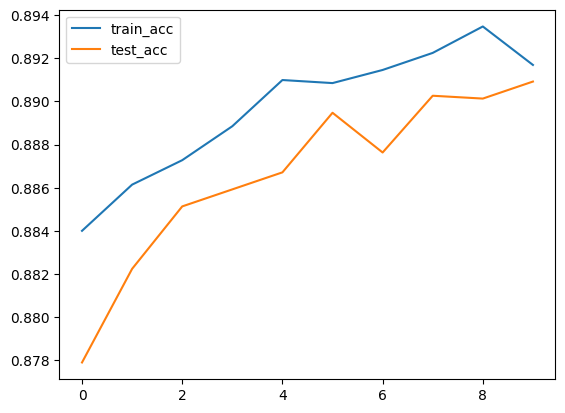

In [32]:
import matplotlib.pyplot as plt

def plot_acc(train_acc_list, test_acc_list, label1='train_acc', label2='test_acc'):
    x = np.arange(len(train_acc_list))

    plt.plot(x, train_acc_list, label=label1)
    plt.plot(x, test_acc_list, label=label2)
    plt.legend()
    plt.show()

plot_acc(train_acc_list, test_acc_list)

In [33]:
from torchinfo import summary

# 모델 정보 출력
summary(model, input_size=(64, 400), dtypes=[torch.int64])

Layer (type:depth-idx)                                  Output Shape              Param #
TextClassifier                                          [64, 4]                   --
├─DistilBertModel: 1-1                                  [64, 400, 768]            --
│    └─Embeddings: 2-1                                  [64, 400, 768]            --
│    │    └─Embedding: 3-1                              [64, 400, 768]            (23,440,896)
│    │    └─Embedding: 3-2                              [1, 400, 768]             (393,216)
│    │    └─LayerNorm: 3-3                              [64, 400, 768]            (1,536)
│    │    └─Dropout: 3-4                                [64, 400, 768]            --
│    └─Transformer: 2-2                                 [64, 400, 768]            --
│    │    └─ModuleList: 3-5                             --                        (42,527,232)
├─Linear: 1-2                                           [64, 4]                   3,076
Total params: 66,365,956
